In [1]:
import sys
sys.path.append("/Users/shikim/code/pynta_local/pynta/")

In [2]:
from pynta.postprocessing import *
from ase.visualize import view
import json

# Analyze Species

In [3]:
functional = 'BEEF-vdW'
pseudo = 'PAW'
metal = "Pt" #specify the metal
facet = "fcc111" #specify the facet
lattice_constant = 3.91 

In [4]:
path = "/Users/shikim/production/pynta-production/for_shinae_hb/nh3-vdw-pt111-forMatt_hb_yesdiffusion_vib/Adsorbates/N[Pt]"

In [5]:
write_slab_db(path,functional,pseudo,lattice_constant,facet)

In [6]:
Es,_,freqs = get_adsorbate_energies(path) #extract species information

In [7]:
Es #energies for each unique successful species calculations

{'0': -426.10433700005524, '1': -426.1046808013343, '3': -425.74558985664044}

In [8]:
freqs #frequencies for each unique successful species calculations

{'0': [(201.94193643655098+0j),
  (327.325887994868+0j),
  (448.04500209129316+0j),
  (693.1445085208824+0j),
  (760.2628099610442+0j),
  (796.7789391711783+0j),
  (1512.1449293653186+0j),
  (3417.409723845569+0j),
  (3522.248035644658+0j)],
 '1': [(211.8867947336871+0j),
  (326.892083497916+0j),
  (446.25050331692535+0j),
  (690.9968184328053+0j),
  (762.7389128602521+0j),
  (795.4641156526192+0j),
  (1513.3750294518761+0j),
  (3424.1433741129254+0j),
  (3528.5185907435452+0j)],
 '3': [30.252499503843005j,
  (72.18077245886064+0j),
  (112.93205447505244+0j),
  (476.46572985938855+0j),
  (723.0357462933347+0j),
  (874.0123242915435+0j),
  (1495.741000991355+0j),
  (3379.0603726260483+0j),
  (3485.0127210691926+0j)]}

In [9]:
json.load(open(os.path.join(path,"info.json"))) #General Species Information

{'name': 'N[Pt]',
 'adjlist': '1 N u0 p1 c0 {2,S} {3,S} {4,S}\n2 H u0 p0 c0 {1,S}\n3 H u0 p0 c0 {1,S}\n4 X u0 p0 c0 {1,S}\n',
 'atom_to_molecule_atom_map': {'0': 0, '1': 1, '2': 2},
 'gratom_to_molecule_surface_atom_map': {'0': 0},
 'nslab': 36}

In [10]:
for d in os.listdir(path): #display all of the species geometries
    if d != "info.json" and os.path.exists(os.path.join(path,d,"vib.json_vib.json")):
        view(read(os.path.join(path,d,d+".xyz")))     

In [11]:
ind = 0 #display species geometry associated with specified index
view(read(os.path.join(path,str(ind),str(ind)+".xyz")))

In [12]:
write_adsorbate_db(path,functional,pseudo,freqs)

# Analyze Transition State


In [13]:
path = "/Users/shikim/production/pynta-production/for_shinae_hb/nh3-vdw-pt111-forMatt_hb_yesdiffusion_vib/TS0"#specify the TS directory to analyze
metal = "Pt" #specify the metal
facet = "fcc111" #specify the facet

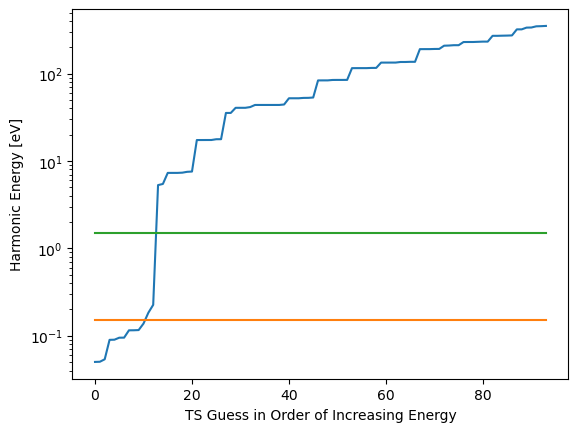

In [14]:
plot_eharm(path,Eharmtol=3.0,Eharmfiltertol=30.0) #plot the harmonic energies of the transition state guesses and cutoffs 

In [15]:
Es,thermos,freqs = get_energies(path) #extract transition state information

In [16]:
Es #energies for each unique successful saddle point optimization

{'66': -782.8996406454244, '62': -783.0919547639205, '84': -782.9653538080165}

In [17]:
freqs #frequencies for each unique successful saddle point optimization

{'66': array([  0.        +636.22534109j, 207.31346786  +0.j        ,
        239.28630439  +0.j        , 361.5459269   +0.j        ,
        366.22945112  +0.j        , 452.3258527   +0.j        ]),
 '62': array([  0.        +533.25395524j, 233.47600812  +0.j        ,
        311.8400834   +0.j        , 433.6942544   +0.j        ,
        517.43504863  +0.j        , 547.86351313  +0.j        ]),
 '84': array([  0.        +515.82921591j, 220.43032856  +0.j        ,
        292.49191149  +0.j        , 434.61524873  +0.j        ,
        515.69024417  +0.j        , 542.59617987  +0.j        ])}

In [18]:
info = json.load(open(os.path.join(path,"info.json"),'r')) #General Transition State Information
info

{'forward': True,
 'name': 'N2 + 2X => 2 NX',
 'reactants': '1 *1 N u0 p1 c0 {3,T}\n2 *2 N u0 p1 c0 {4,T}\n3 *3 X u0 p0 c0 {1,T}\n4 *4 X u0 p0 c0 {2,T}\n',
 'products': '1 *1 N u0 p1 c0 {2,T}\n2 *2 N u0 p1 c0 {1,T}\n3 *3 X u0 p0 c0\n4 *4 X u0 p0 c0\n',
 'species_names': ['N#[Pt]', 'N#[Pt]'],
 'nslab': 36,
 'mols': ['1 N u0 p1 c0 {2,T}\n2 X u0 p0 c0 {1,T}\n',
  '1 N u0 p1 c0 {2,T}\n2 X u0 p0 c0 {1,T}\n'],
 'ads_sizes': [1, 1],
 'template_mol_map': [{'2': 1, '0': 0}, {'1': 0, '3': 1}],
 'reverse_names': ['N#N'],
 'molecule_to_atom_maps': [{'0': 0}, {'0': 0}]}

In [19]:
fdEs,rdEs,farrs,rarrs,rthermos,pthermos = get_kinetics(path,metal,facet) #calculate barriers and rate coefficients

In [20]:
info["species_names"] #Reactants in forward direction

['N#[Pt]', 'N#[Pt]']

In [21]:
fdEs #forward barriers

{'66': -782.8996406454244, '62': -783.0919547639205, '84': -782.9653538080165}

In [22]:
farrs #forward rate coefficients

{}

In [23]:
info["reverse_names"] #Reactants in the reverse direction

['N#N']

In [24]:
rdEs #reverse barriers


{'66': 3.6880220452380854, '62': 3.495707926741943, '84': 3.622308882645939}

In [25]:
rarrs #reverse rate coefficients


{'66': SurfaceArrhenius(A=(1.44967e-46,'m^5/(molecules^2*s)'), n=1.96842, Ea=(350.734,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.06173, dn = +|- 0.00758407, dEa = +|- 0.0526812 kJ/mol"""),
 '62': SurfaceArrhenius(A=(9.8604e-47,'m^5/(molecules^2*s)'), n=1.88326, Ea=(330.973,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.03836, dn = +|- 0.00476562, dEa = +|- 0.0331034 kJ/mol"""),
 '84': SurfaceArrhenius(A=(1.06737e-46,'m^5/(molecules^2*s)'), n=1.88958, Ea=(343.323,'kJ/mol'), T0=(1,'K'), Tmin=(298,'K'), Tmax=(2500,'K'), comment="""Fitted to 50 data points; dA = *|/ 1.0395, dn = +|- 0.00490539, dEa = +|- 0.0340743 kJ/mol""")}

In [26]:
get_gibbs_energy_reaction(rthermos,pthermos,298.)/1000.0 #Gibbs free energy of reaction at 298 K in kJ/mol

-75943.42639498618

In [27]:
get_entropy_reaction(rthermos,pthermos,298.) #Entropy of reaciton at 298 K in J/(mol K)

197.45916810492312

In [28]:
get_enthalpy_reaction(rthermos,pthermos,298.)/1000.0 #Enthalpy of reaction at 298 K in kJ/mol

-75884.58356289091

In [29]:
rate_data = parse_all_surface_arrhenius(rarrs)
write_rate_db(path,rate_data)

In [31]:
write_ts_db(path,functional,pseudo,freqs)

# Look at Individual TS 

In [ ]:
ind = "66" #specify the index of the transition state to examine
tsdir = os.path.join(path,ind)

In [ ]:
view(read(os.path.join(tsdir,"opt.xyz"))) #TS geometry

In [ ]:
tr = Trajectory(os.path.join(tsdir,"irc_forward.traj")) #first IRC
view(tr)

In [ ]:
tr = Trajectory(os.path.join(tsdir,"irc_reverse.traj")) #second IRC
view(tr)

In [ ]:
tr = Trajectory(os.path.join(tsdir,'vib.0.traj')) #Imaginary Mode
view(tr)